# 7th-December-2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, HTML, display

## Table of contents/Summary

1. About SVD and eigen solvers of PETSc, eigen3, Python, and MATLAB
2. Inner product metric for applying the update seems to be only valid for real-valued dominant modes
3. Sigma ratio and proper modal decomposition
4. Eigenvalue convergence of DMD
5. Some extra notes and discussion...
***

## 1. SVD and Eigen solvers - numerical errors
### SVD
The lapack algorithm of PETSc gives the closest results to Python and MATLAB (with correct signs). However, this algorithm should only be used  for small matrices because it's slow.  
SVD Lanczos gives accurate update calculations, but the signs for U and V are different than Lapack. However, it follows the SVD properties.  
Signularvalues are the same for both methods.

These differences result in different Atilde (order of 1e-4 and sign differences)
### Eigendecomposition

For the same $\tilde{A}$, Python, PETSc, and Eigen3 give the same eigenvalues (small differences) and give similar eigenvectors but in different scales.  
For example, one eigenvector is a multiple of the same eigenvector computed with another algorithm.

I completed the implementation of DMD mode computation. Because of these differences in eigen system solver, we get different values for DMD modes and their dot product with the solution or solution update.  
But I think SLEPc's EPS is more useful (at least compared to eigen3):
1. It gives ordered eigenvalues, giving us ordered DMD modes.
2. The dot product values are more consistent. (reasonable values in order, better consistent showing of the energy of DMD modes in our solution)
***

## 2. Inner product metric
This worked for the Newtonian2D and Poisson2D physics. For these two cases, wherever we applied the update we were dealing with real-valued dominant modes and not complex conjugate pair.
***

## 3. Sigma ratio and proper modal decomposition

As discussed before, singularvalues can give us info on mode separation. I think for the sigma ratios,  $\dfrac{\sigma_3}{\sigma_1}$ would be a better choice.  
It is because we might have a complex conjugate pair to be dominant or a real-valued mode as the dominant one. In any case, we are comparing singularvalues of 2 different modes, not the same modes.

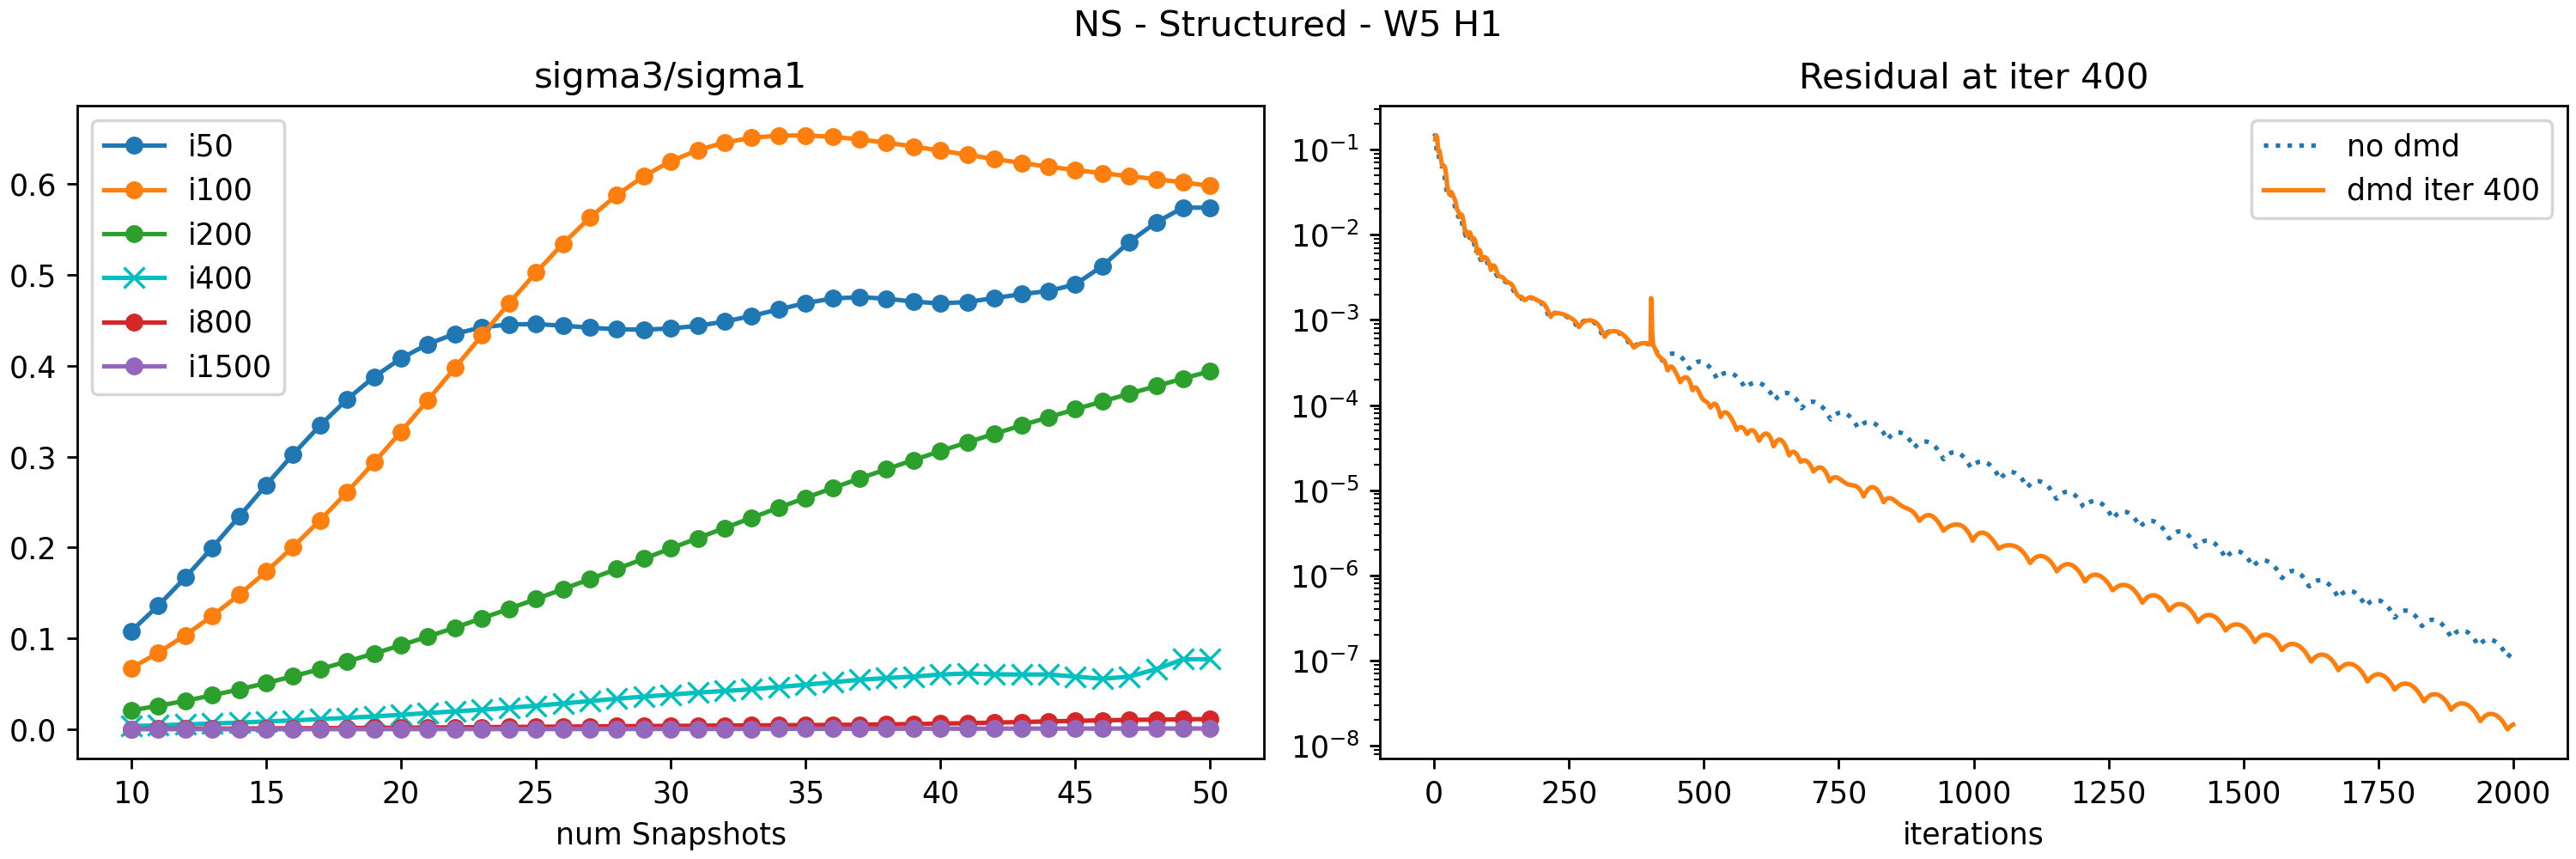

In [2]:
Image("NS-W5-sv1.png")

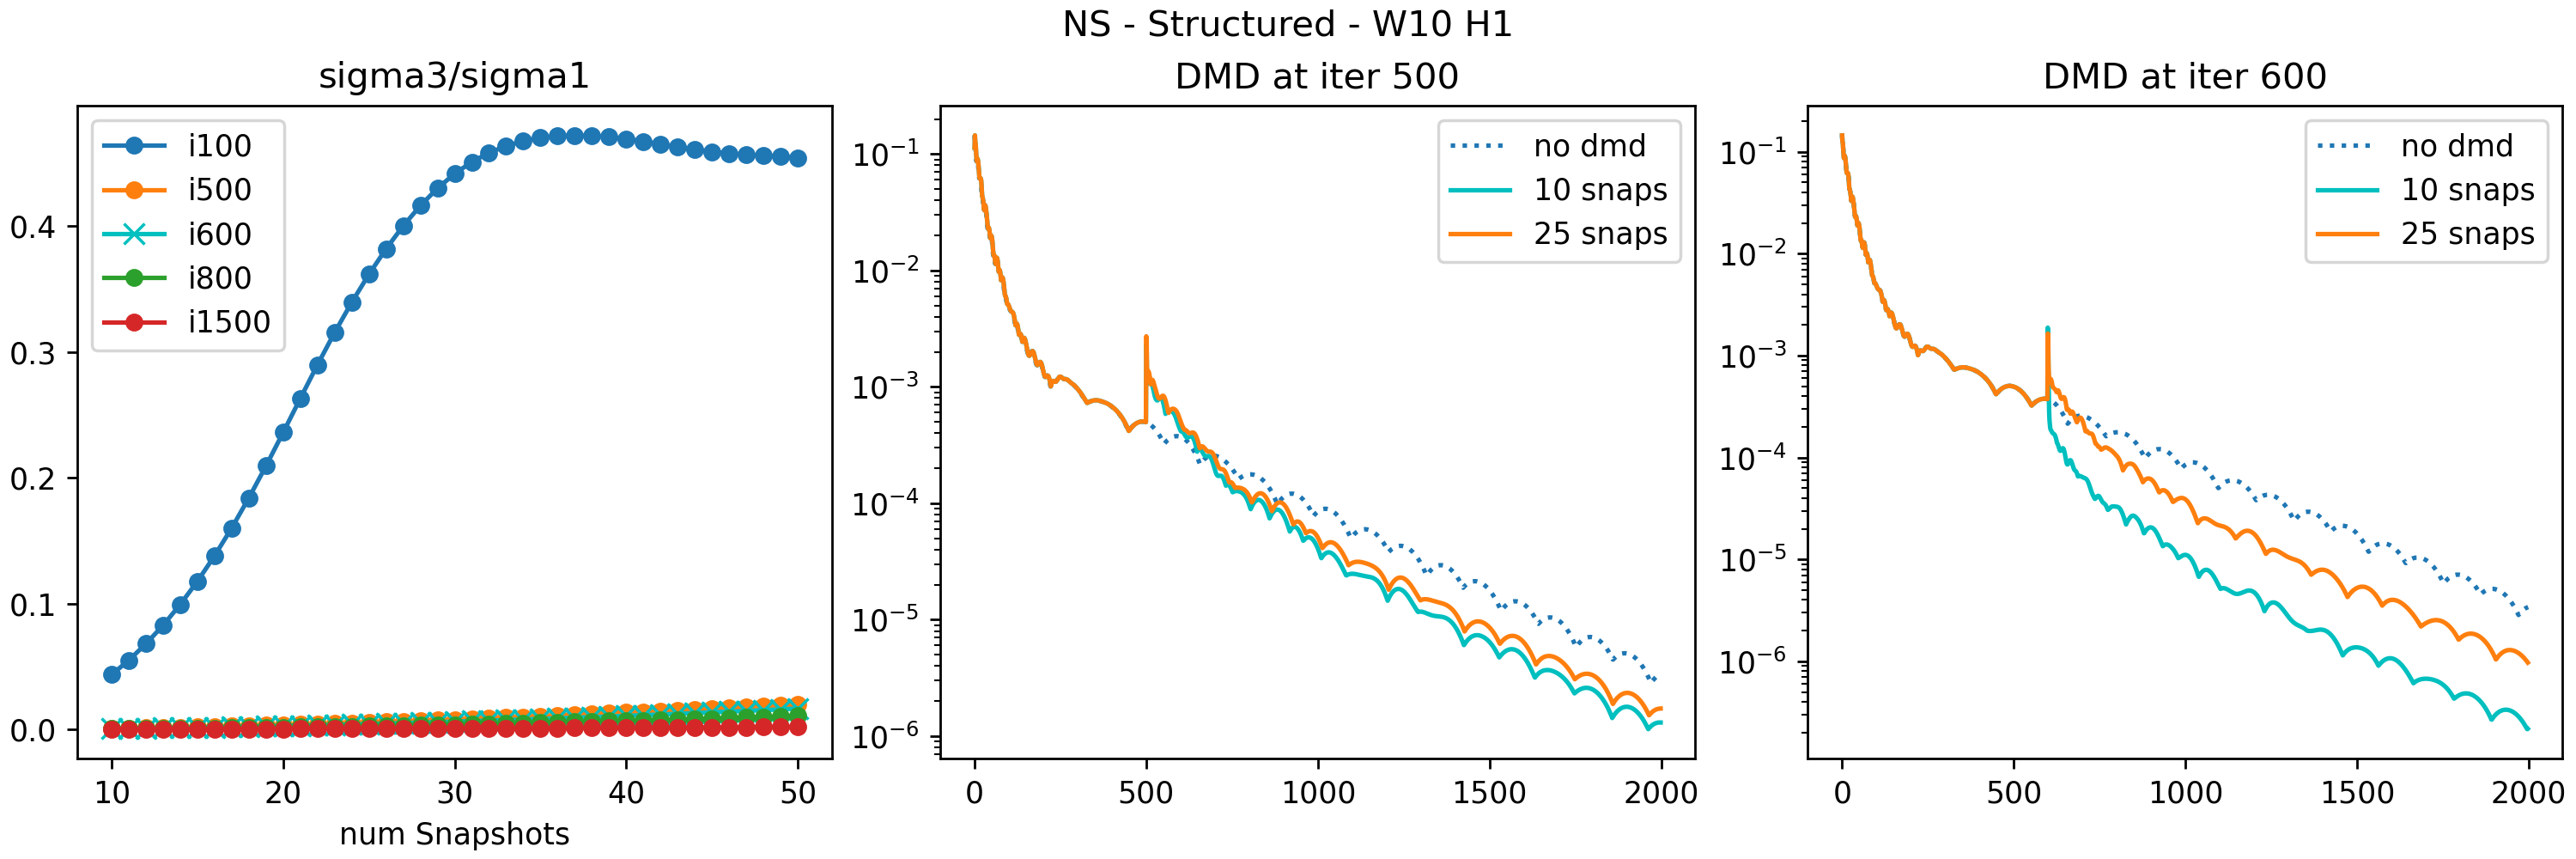

In [3]:
Image("NS-W10-sv1.png")

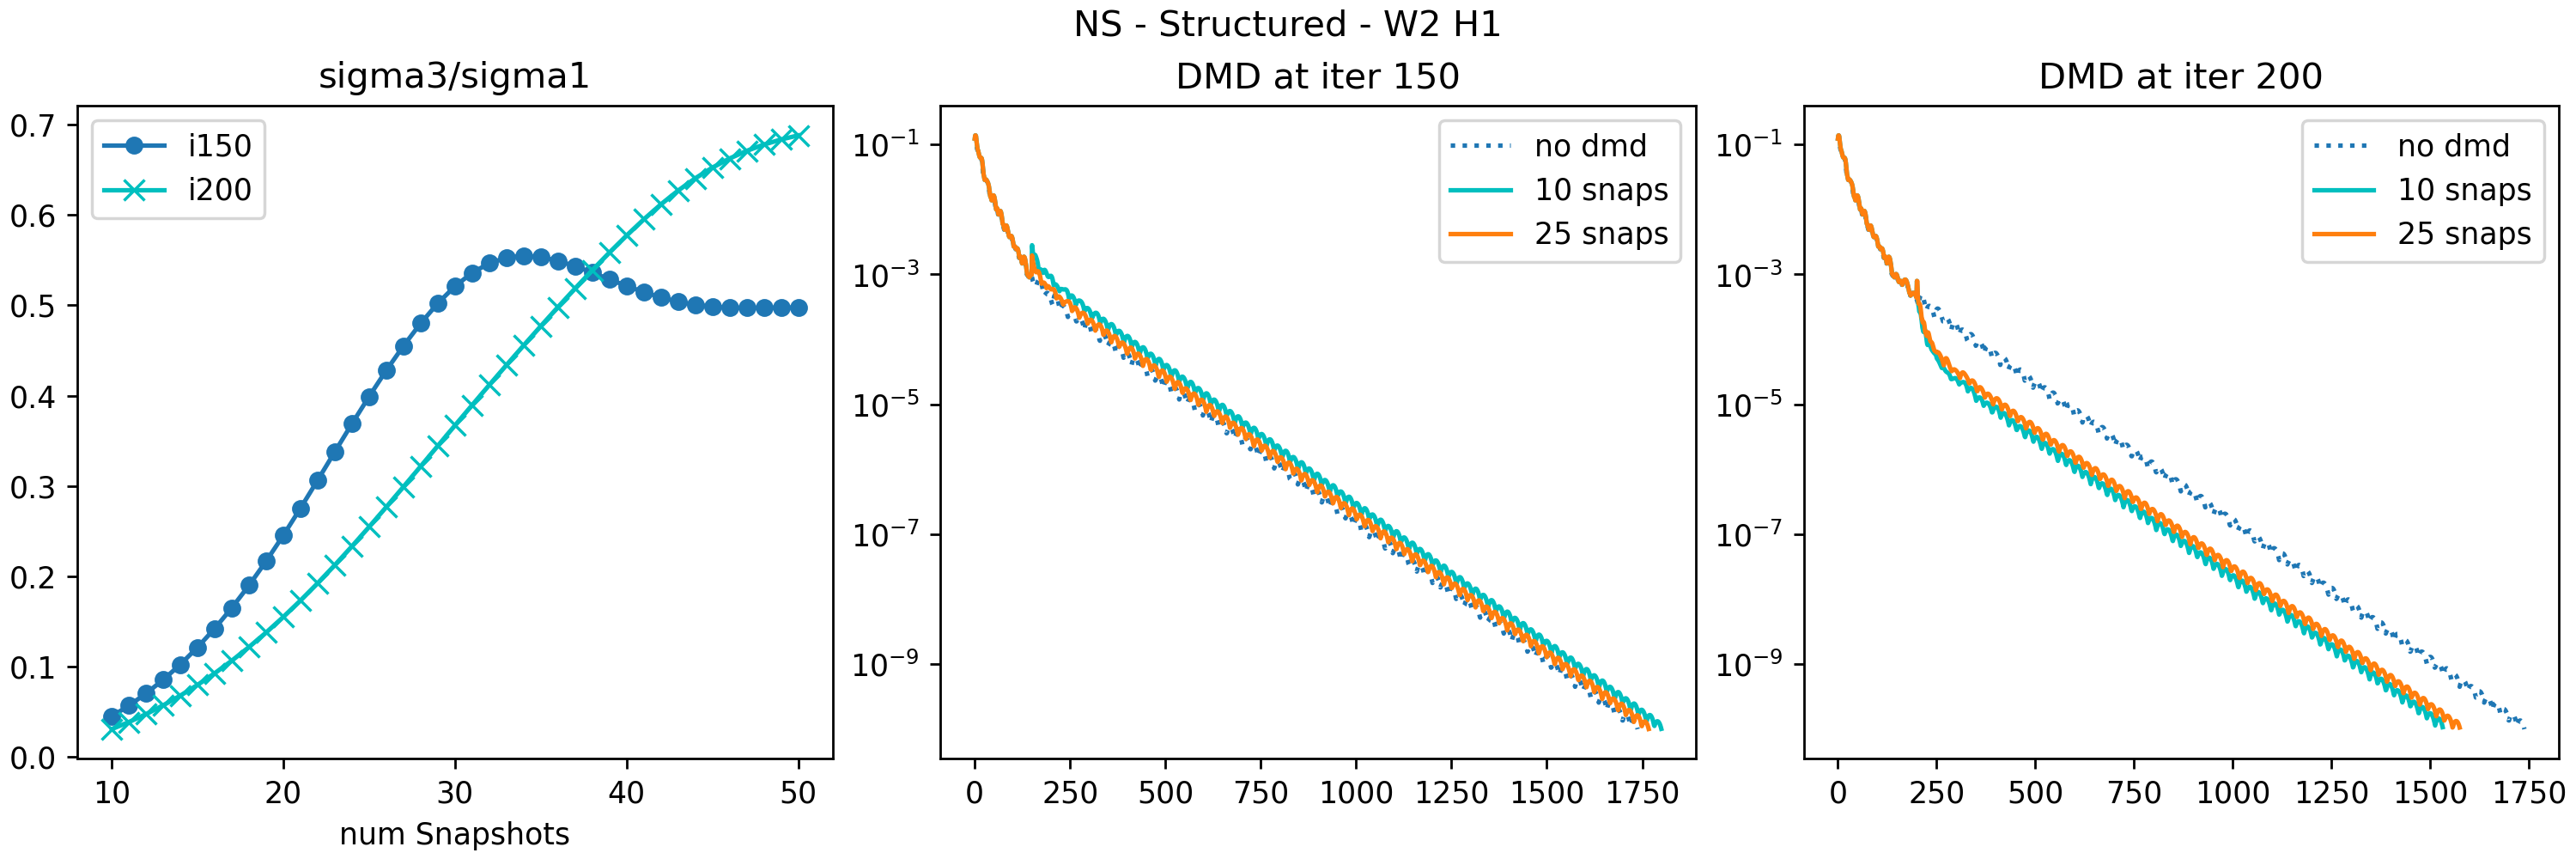

In [4]:
Image("NS-W2-sv1.png")

This 3rd example shows that these ratios cannot be predicted for all geometries and physics.  
Also another example in Newtonian2D had a small sigma ratio, but the update was not effective.

<strong>This brought me the question that how should we connect singularvalues to the DMD modes (amplification factors)?</strong>
***

## 4. Eigenvalue convergence of DMD

The question I am asking here:  
* Is the first singularvalue corresponding to the dominant mode? and the 2nd sigma related to the second dominant mode?  
It appears that this is not the case.

The figure below is for Poisson2D problem.  
<strong>Note: using more snapshots give more accurate eigenvalues, but we need to include more singularvalues to achieve this more accurate results.</strong>

For example, if we use 50 snapshots, we might be able to increase the rank to get 5 accurate DMD modes. But with 10 snapshots, even if we use all the 9 modes, we can only reconstruct up to 4 modes.

Maybe we should find a relation between SVD-truncation and the eigenvalues of $\tilde{A}$.

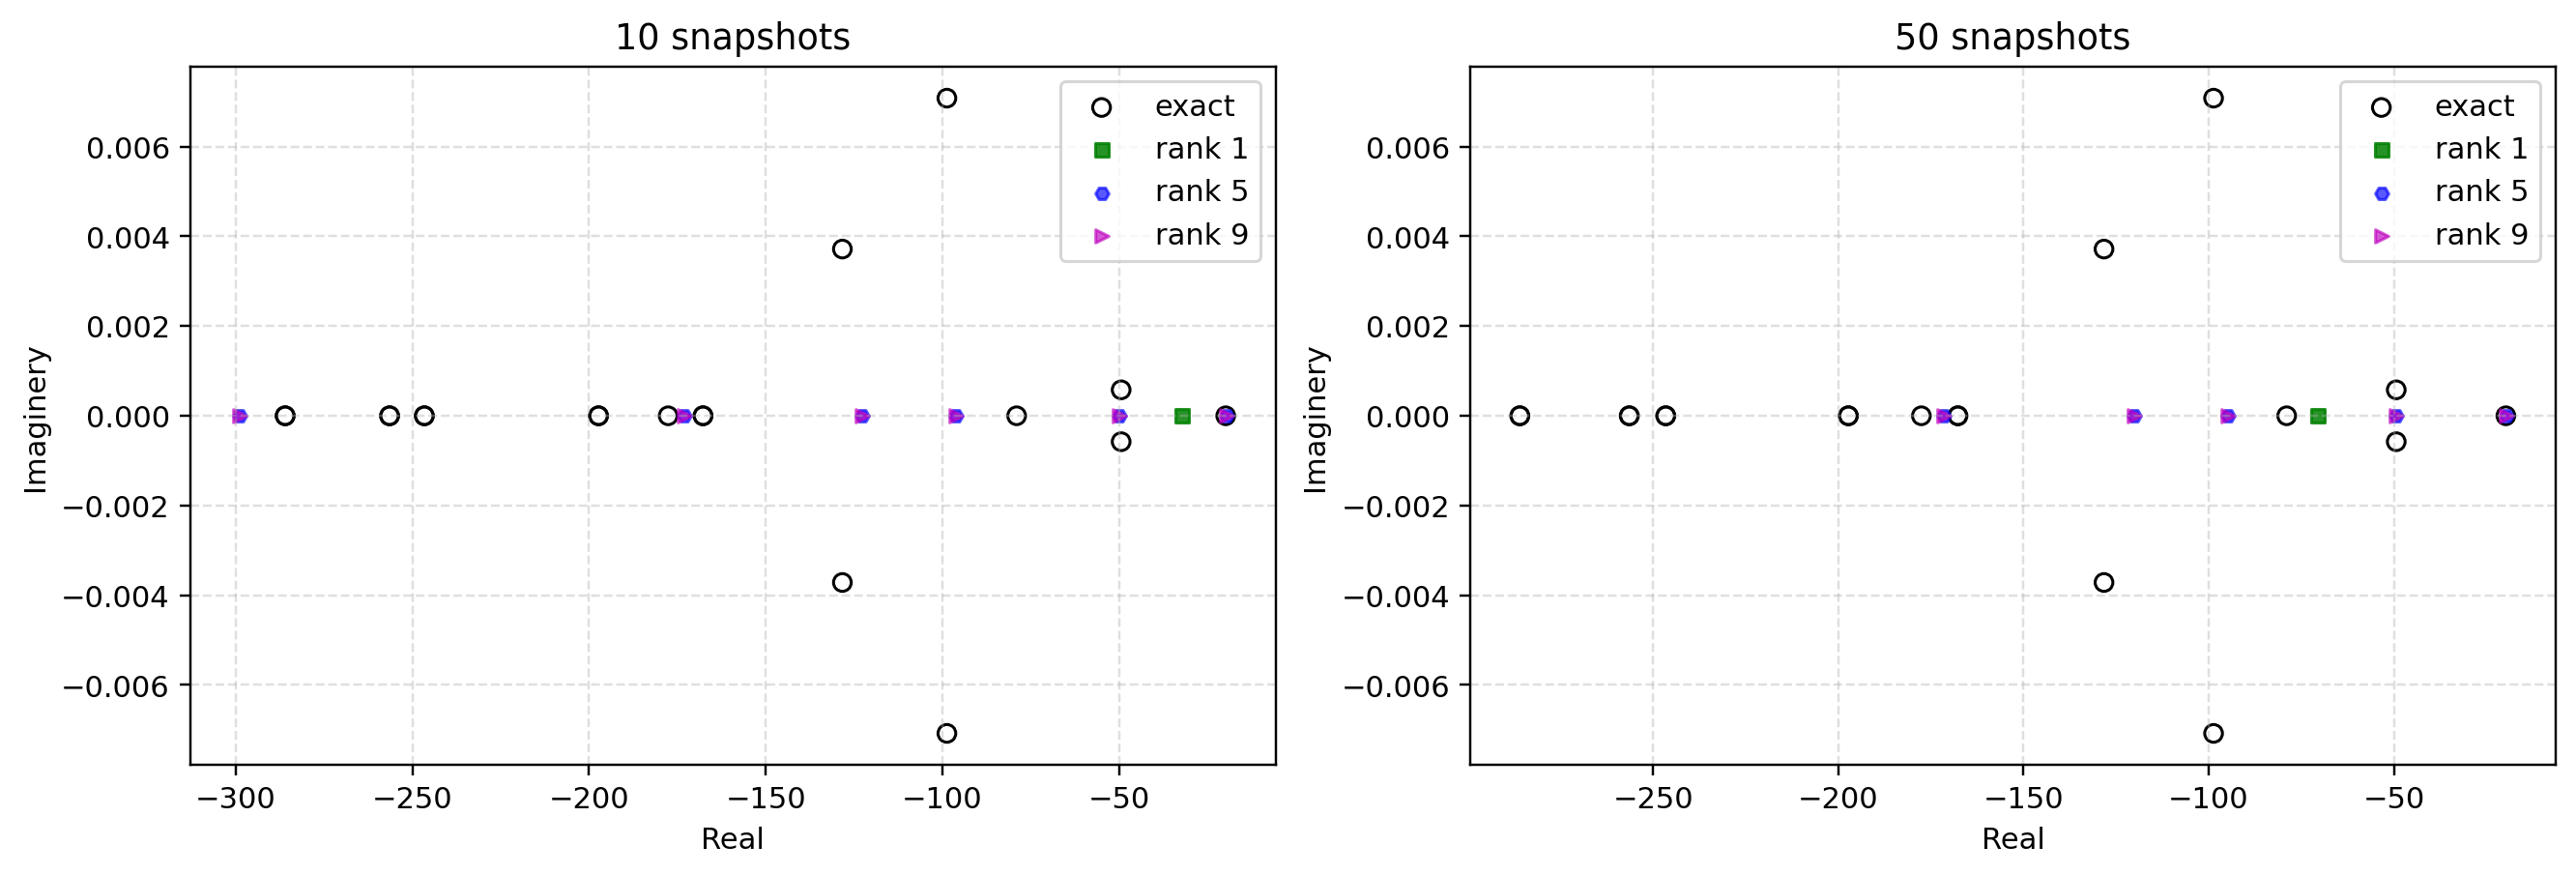

In [5]:
Image("eigenvalue_convergence.png")

## 5. Some extra notes and discussion...

1. We developed two methods for over-relaxation using modal decomposition:
    - Computing the update, using the Krylov sequence spanned by $\tilde{A}$
    - Compute the update, using DMD modes and their time-dynamics  

    The first method is easy and hassle-free to compute. But we don't know what modes we are eliminating.  
    The second methods gives us the control on modes and we can decide which mode to eliminate and we have all the details about these modes. But it need more code implementation and might be slower because of for loops and summing different modes to get a single update.

    Although in effect we can get the same reasonable update from both of these methods, the 2nd one provides more info which is better for analysis. Because we know all the details about our update. (in this case we don't have the problems discussed in part 4 of this report)

2. After analyzing the $\tilde{A}$, I think the rows are related to each U modes, the columns are related to each V vectors.
3. We might be able to use the amount of cumulative energy for mode selection. (should be tested)  
    cdS = cumsum(DMD1.S)./sum(DMD1.S)  
    r90 = min(find(cdS>0.90))

***
***

# Appendix
notes to myself

1. SVD lapack is the closest to the SVD of Python and MATLAB
    - SVD Lanczos is different by mostly the signs, and small difference in some values (mostly of order 1e-5, few of order 1e-4)
    - for V, mostly the signs are different, and their difference is of order 1e-7
    - Singularvalues are the same for all the methods

2. Atilde, with SVDLANCOZ has difference of order 1e-4, and sign differences

## Residual of the DMD algorithm
By using more snapshots the DMD algorithm converges. Meaning the eigenvalues of the small space ($\tilde{A}$) converge to the eigenvalues of the high-dimensional space ($A$).  
Obviously our error in computation of the DMD algorithm should not be larger than the solution error norm. So maybe we can compare the error norm of DMD with the solution's L2-norm, and if the error in DMD is higher than the solution error norm, we should discard the DMD update.